# 10-5. 프로젝트: 개선된 U-Net 모델 만들기
U-Net으로 도로 시맨틱 세그멘테이션을 진행해봤다.   

2018년에 U-Net++ 논문이 나왔다. 기존 U-Net 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델이다. 그리고 논문은 2020년에 한 번 업그레이드 되었다.

- [U-Net++: v1](https://arxiv.org/abs/1807.10165)
- [U-Net++: v2](https://arxiv.org/abs/1912.05074)
- [U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus/tree/master/keras)

Semantic Segmenation을 이용해서 자율주행 차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보자.   
U-Net을 개선해서 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어보자.

# 1. KITTI 데이터셋 수집, 구축

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

augmentation을 만든 후 데이터가 잘 파싱되어 나오는지 확인해보자.

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
                        HorizontalFlip(p=0.5),
                        RandomSizedCrop(
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                        ),
                        Resize(width=224,height=224)
                        ])
    return Compose([
                    Resize(width=224, height=224)
                    ])

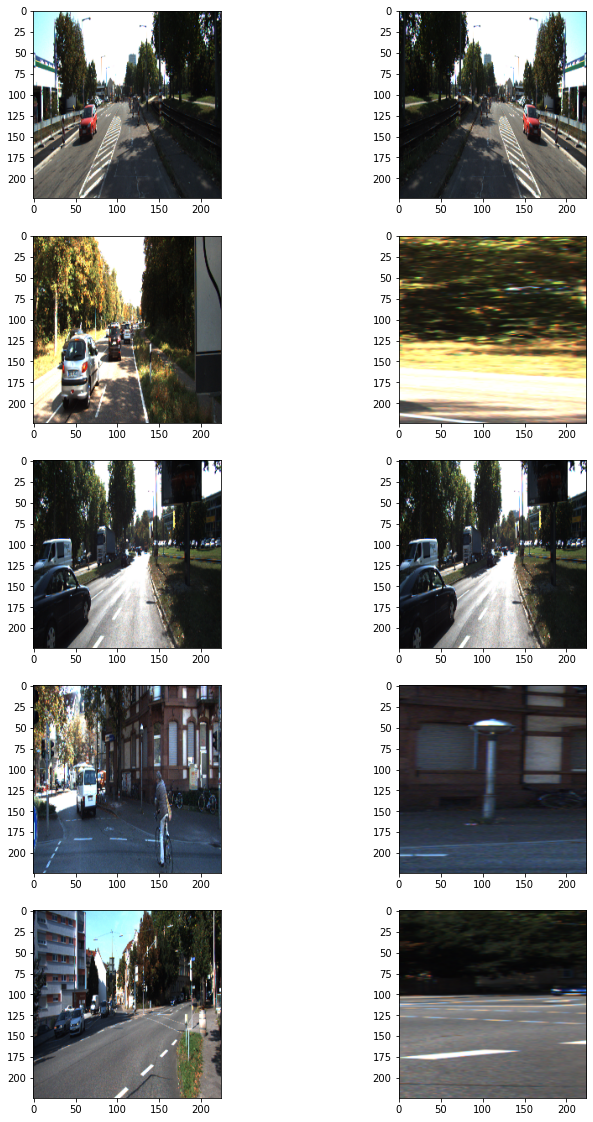

In [3]:
dir_path = "/content/drive/MyDrive/aiffel_dataset/GD10_semantic_segmenation/training"

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"]) # 좌측 원본
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"]) # 우측 augment

plt.show()

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성하자.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=4, # 16 -> 4로 배치 사이즈 변경
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        # load_dataset()을 통해 kitti dataset의 directory path에서 라벨의 이미지를 확인한다.
        self.data = self.load_dataset()
    
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[:-30]

    def __len__(self):
        # generator의 length, 전체 dataset을 batch_size로 나누고 소숫점 첫째에서 올림한 값 반환한다.
        return math.ceil(len(self.data)/self.batch_size)

    # 입출력 만들기
    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:
                               (index+1)*self.batch_size]
        # 입력은 resize, augment 적용된 input image, 출력은 semenatic label
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
    
    # 1 epoch가 끝나면 실행되는 함수이다.
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_tarin == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

# 2. U-Net++ 모델 구현
![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-5-P-UNPP.max-800x600.png)

![]()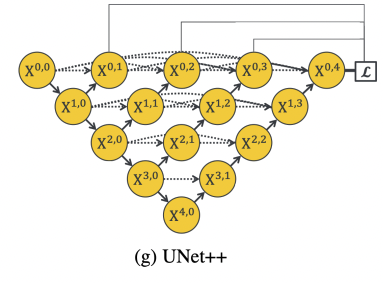

In [33]:
def standard_unit(input, filter):
    drop_rate = 0.5
    x = Conv2D(filter, kernel_size=3, actiaction="relu", padding="same", kernel_initializer="he_normal")(input)
    x = Dropout(drop_rate)(x)
    x = Conv2D(filter, kernel_size=3, actiaction="relu", padding="same", kernel_initializer="he_normal")(x)
    x = Dropout(drop_rate)(x)
    return x

def Unet_plus_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # backbone, down sampling
    # X_0_0
    backbone_conv_0 = Conv2D(64, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(inputs)
    backbone_0 = MaxPooling2D(pool_size=2)(backbone_conv_0)

    # X_1_0
    backbone_conv_1 = Conv2D(128, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_0)
    backbone_1 = MaxPooling2D(pool_size=2)(backbone_conv_1)

    # X_2_0
    backbone_conv_2 = Conv2D(256, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_1)
    backbone_2 = MaxPooling2D(pool_size=2)(backbone_conv_2)

    # X_3_0
    backbone_conv_3 = Conv2D(512, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_2)
    backbone_3 = MaxPooling2D(pool_size=2)(backbone_conv_3)

    # X_4_0
    backbone_conv_4 = Conv2D(1026, kernel_size=3, activation="relu", padding="same", kernel_initializer="he_normal")(backbone_3)
    backbone_4 = MaxPooling2D(pool_size=2)(backbone_conv_4)
    print("end backbone")

    ###
    # X_0_1
    up_sampling_10 = Conv2DTranspose(64, kernel_size=2, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_conv_1)
    skip_connection_01 = concatenate([backbone_conv_0,up_sampling_10], axis=3)
    print(backbone_conv_1)
    print(up_sampling_10)
    print(skip_connection_01)
    conv01 = standard_unit(skip_connection_01, 64)
    print(conv01)
    
    print("01")

    # X_1_1
    up_sampling_20 = Conv2DTranspose(128, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_conv_2)
    skip_connection_11 = concatenate([backbone_conv_1,up_sampling_20], axis=3)
    conv11 = standard_unit(skip_connection_11, 128)
    print("11")

    # X_2_1
    up_sampling_30 = Conv2DTranspose(256, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_conv_3)
    skip_connection_21 = concatenate([backbone_conv_2,up_sampling_30], axis=3)
    conv21 = standard_unit(skip_connection_21, 256)
    print("21")

    # X_0_2
    up_sampling_11 = Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv11)
    skip_connection_02 = concatenate([backbone_conv_0,conv01,up_sampling_11], axis=3)
    conv02 = standard_unit(skip_connection_02, 64)
    print("02")

    # X_1_2
    up_sampling_21 = Conv2DTranspose(128, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv21)
    skip_connection_12 = concatenate([backbone_conv_1,conv11,up_sampling_21], axis=3)
    conv12 = standard_unit(skip_connection_12, 128)
    
    # X_0_3
    upsampling_12 = Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv02)
    skip_connection_03 = concatenate([backbone_conv_0,conv01,conv02,upsampling_12], axis=3)
    conv03 = standard_unit(skip_connection_03, 64)

    # X_3_1
    upsampling_40 = Conv2DTranspose(512, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(backbone_4)
    skip_connection_31 = concatenate([backbone_conv_3,upsampling_40], axis=3)
    conv31 = standard_unit(skip_connection_31, 512)
    
    # X_2_2
    upsampling_31 = Conv2DTranspose(256, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv31)
    skip_connection_22 = concatenate([backbone_conv_2,conv21,upsampling_31], axis=3)
    conv22 = standard_unit(skip_connection_22, 256)

    # X_1_3
    upsampling_22 = Conv2DTranspose(128, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv22)
    skip_connection_13 = concatenate([backbone_conv_1,conv11,conv12,upsampling_22], axis=3)
    conv13 = standard_unit(skip_connection_13, 128)

    # X_0_4
    upsampling_13 = Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same", kernel_initializer='he_normal')(conv13)
    skip_connection_04 = concatenate([backbone_conv_0,conv01,conv02,conv03,upsampling_13], axis=3)
    conv04 = standard_unit(skip_connection_04, 64)

    Unet_plus_output = Conv2D(1, 3, activation='sigmoid', padding="same")(conv04)


    model = Model(inputs=inputs, outputs=Unet_plus_output)
    return model

In [34]:
model = Unet_plus_model(input_shape=(224, 224, 3))
model.summary()

end backbone
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='conv2d_61/Relu:0', description="created by layer 'conv2d_61'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='conv2d_transpose_13/Relu:0', description="created by layer 'conv2d_transpose_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 128), dtype=tf.float32, name=None), name='concatenate_13/concat:0', description="created by layer 'concatenate_13'")


TypeError: ignored